### Install Things

In [1]:
!pip install pandasql --quiet

### Import Things

In [2]:
import numpy as np
import pandas as pd
import pandasql as psql
import warnings
from pandas.errors import SettingWithCopyWarning

pd.set_option("display.max_columns", None)
warnings.simplefilter(action = "ignore", category = SettingWithCopyWarning)

### Some Functions

In [3]:
# Keep only shots and goals function
def keep_SOG(df):
    df = df[(df["typeDescKey"] == "shot-on-goal") | (df["typeDescKey"] == "goal")]

    return(df)

In [4]:
# Fix pbp data types
def fix_pbp_types(pbp_df):
    pbp_df["situationCode"] = pbp_df["situationCode"].astype(int).astype(str).str.pad(width = 4, side = "left", fillchar = "0")
    pbp_df["gameId"] = pbp_df["gameId"].astype(str)
    pbp_df["periodDescriptor.number"] = pbp_df["periodDescriptor.number"].astype(int)
    pbp_df["details.eventOwnerTeamId"] = pbp_df["details.eventOwnerTeamId"].astype(int).astype(str)

    return(pbp_df)

In [5]:
# Fix schedule data types
def fix_schedule_types(schedule_df):
    schedule_df["id"] = schedule_df["id"].astype(str)
    schedule_df["awayTeam.id"] = schedule_df["awayTeam.id"].astype(str)
    schedule_df["homeTeam.id"] = schedule_df["homeTeam.id"].astype(str)

    return(schedule_df)

### Get Data

In [6]:
skaters = pd.read_csv("skaters.csv")
goalies = pd.read_csv("goalies.csv")
pbp = pd.read_csv("pbp.csv")
schedule = pd.read_csv("schedule.csv")
pbp.head()

/var/folders/5k/vm4wbtfd3hz2hq37wm4d1_8h0000gp/T/ipykernel_8014/863690396.py:3: DtypeWarning: Columns (45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv("pbp.csv")


,eventId,timeInPeriod,timeRemaining,situationCode,homeTeamDefendingSide,typeCode,typeDescKey,sortOrder,periodDescriptor.number,periodDescriptor.periodType,periodDescriptor.maxRegulationPeriods,details.eventOwnerTeamId,details.losingPlayerId,details.winningPlayerId,details.xCoord,details.yCoord,details.zoneCode,details.hittingPlayerId,details.hitteePlayerId,details.shotType,details.shootingPlayerId,details.goalieInNetId,details.awaySOG,details.homeSOG,details.reason,details.typeCode,details.descKey,details.duration,details.committedByPlayerId,details.drawnByPlayerId,details.blockingPlayerId,details.playerId,details.secondaryReason,details.scoringPlayerId,details.scoringPlayerTotal,details.assist1PlayerId,details.assist1PlayerTotal,details.assist2PlayerId,details.assist2PlayerTotal,details.awayScore,details.homeScore,details.discreteClip,details.servedByPlayerId,gameId,periodDescriptor.otPeriods,pptReplayUrl,details.highlightClipSharingUrl,details.highlightClipSharingUrlFr,details.highlightClip,details.highlightClipFr,details.discreteClipFr
0,51.0,00:00,20:00,1551.0,right,520.0,period-start,8.0,1.0,REG,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021010001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,53.0,00:00,20:00,1551.0,right,502.0,faceoff,9.0,1.0,REG,3.0,10.0,8480018.0,8475166.0,0.0,0.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021010001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101.0,00:15,19:45,1551.0,right,503.0,hit,10.0,1.0,REG,3.0,10.0,NaN,NaN,-96.0,26.0,O,8475166.0,8481014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021010001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54.0,00:17,19:43,1551.0,right,506.0,shot-on-goal,11.0,1.0,REG,3.0,10.0,NaN,NaN,-49.0,7.0,O,NaN,NaN,snap,8480043.0,8480051.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021010001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55.0,00:27,19:33,1551.0,right,507.0,missed-shot,12.0,1.0,REG,3.0,10.0,NaN,NaN,-31.0,39.0,O,NaN,NaN,wrist,8480043.0,8480051.0,NaN,NaN,wide-of-net,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021010001,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Fix universal dataset data types
schedule = fix_schedule_types(schedule)

### Split Play-By-Play Into Train (2021-22, 2022-23, 2023-24) and Test (2024-25), Additionally Filter for Regular Season Only

In [8]:
# Set "gameId" to a string
pbp["gameId"] = pbp["gameId"].apply(str)

# Split into training and testing events
train_pbp = pbp.loc[pbp.gameId.str.startswith(("2021", "2022", "2023"), na=False)]
test_pbp = pbp.loc[pbp.gameId.str.startswith("2024", na=False)]
print("Training events: ", len(train_pbp))
print("Testing events: ", len(test_pbp))

Training events:  1404747
Testing events:  479352


In [9]:
# Keep only regular season games (remove pre-season and playoffs)
train_pbp = train_pbp.loc[train_pbp["gameId"].str[5] == "2"]
test_pbp = test_pbp.loc[test_pbp["gameId"].str[5] == "2"]
print("Training events: ", len(train_pbp))
print("Testing events: ", len(test_pbp))

Training events:  1227064
Testing events:  420073


### [Krzywicki (2005)](https://www.hockeyanalytics.com/Research_files/Shot_Quality_Krzywicki.pdf)

In [10]:
# Variables
# - Distance (<10ft, 10ft-12ft, 13ft-14ft, 15ft-16ft, 17ft-22ft, 23ft-31ft, 32ft-36ft, 37ft-38ft
#             39ft-44ft, 45ft-57ft, >=58ft)
# - Shot Type (Wrap, Slap, Wrist, Snap, Backhand, Tip)
# - Rebound (Yes, No)
# - Situation (Even Strength, Shorthanded, Powerplay)

In [11]:
# Keep only shot and goal events
train_pbp_krzy05 = keep_SOG(train_pbp)
test_pbp_krzy05 = keep_SOG(test_pbp)
print("Training shots: ", len(train_pbp_krzy05))
print("Testing shots: ", len(test_pbp_krzy05))

Training shots:  246134
Testing shots:  74641


In [12]:
# Fix data types
train_pbp_krzy05 = fix_pbp_types(train_pbp_krzy05)
test_pbp_krzy05 = fix_pbp_types(test_pbp_krzy05)

In [13]:
# Reduce columns to those neccesary for the model
keep_pbp = ["timeInPeriod", "timeRemaining", "situationCode", "typeDescKey", "periodDescriptor.number", "details.eventOwnerTeamId", "details.xCoord", "details.yCoord", "details.shotType", "gameId", "homeTeamDefendingSide"]
keep_schedule = ["id", "awayTeam.id", "homeTeam.id"]
train_pbp_krzy05 = pd.merge(train_pbp_krzy05[keep_pbp],schedule[keep_schedule], left_on = "gameId", right_on = "id", how = "inner")
test_pbp_krzy05 = pd.merge(test_pbp_krzy05[keep_pbp],schedule[keep_schedule], left_on = "gameId", right_on = "id", how = "inner")
train_pbp_krzy05.head()

,timeInPeriod,timeRemaining,situationCode,typeDescKey,periodDescriptor.number,details.eventOwnerTeamId,details.xCoord,details.yCoord,details.shotType,gameId,homeTeamDefendingSide,id,awayTeam.id,homeTeam.id
0,00:15,19:45,1551,shot-on-goal,1,8,71.0,13.0,slap,2021020003,right,2021020003,8,10
1,00:18,19:42,1551,shot-on-goal,1,8,78.0,-22.0,wrist,2021020003,right,2021020003,8,10
2,01:16,18:44,1551,shot-on-goal,1,10,-60.0,-18.0,wrist,2021020003,right,2021020003,8,10
3,01:23,18:37,1551,shot-on-goal,1,8,64.0,-16.0,wrist,2021020003,right,2021020003,8,10
4,02:50,17:10,1551,shot-on-goal,1,8,31.0,20.0,slap,2021020003,right,2021020003,8,10


In [14]:
# Drop rows with details.shotType (38 train, 24 test), this is the only column containing NaN
train_pbp_krzy05 = train_pbp_krzy05[train_pbp_krzy05["details.shotType"].notna()]
test_pbp_krzy05 = test_pbp_krzy05[test_pbp_krzy05["details.shotType"].notna()]
print("Training shots: ", len(train_pbp_krzy05))
print("Testing shots: ", len(test_pbp_krzy05))

Training shots:  246096
Testing shots:  74617


In [19]:
#Create an abs.xCoord column, so shots are in one direction
train_pbp_krzy05["abs.xCoord"] = train_pbp_krzy05["details.xCoord"].abs()
test_pbp_krzy05["abs.xCoord"] = test_pbp_krzy05["details.xCoord"].abs()

# Determine whether home team took the shot
train_pbp_krzy05["homeTeamShot"] = train_pbp_krzy05["details.eventOwnerTeamId"] == train_pbp_krzy05["homeTeam.id"]
test_pbp_krzy05["homeTeamShot"] = test_pbp_krzy05["details.eventOwnerTeamId"] == test_pbp_krzy05["homeTeam.id"]

train_pbp_krzy05.head()

,timeInPeriod,timeRemaining,situationCode,typeDescKey,periodDescriptor.number,details.eventOwnerTeamId,details.xCoord,details.yCoord,details.shotType,gameId,homeTeamDefendingSide,id,awayTeam.id,homeTeam.id,homeTeamShot,abs.xCoord
0,00:15,19:45,1551,shot-on-goal,1,8,71.0,13.0,slap,2021020003,right,2021020003,8,10,False,71.0
1,00:18,19:42,1551,shot-on-goal,1,8,78.0,-22.0,wrist,2021020003,right,2021020003,8,10,False,78.0
2,01:16,18:44,1551,shot-on-goal,1,10,-60.0,-18.0,wrist,2021020003,right,2021020003,8,10,True,60.0
3,01:23,18:37,1551,shot-on-goal,1,8,64.0,-16.0,wrist,2021020003,right,2021020003,8,10,False,64.0
4,02:50,17:10,1551,shot-on-goal,1,8,31.0,20.0,slap,2021020003,right,2021020003,8,10,False,31.0


/Users/acer1/miniconda3/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


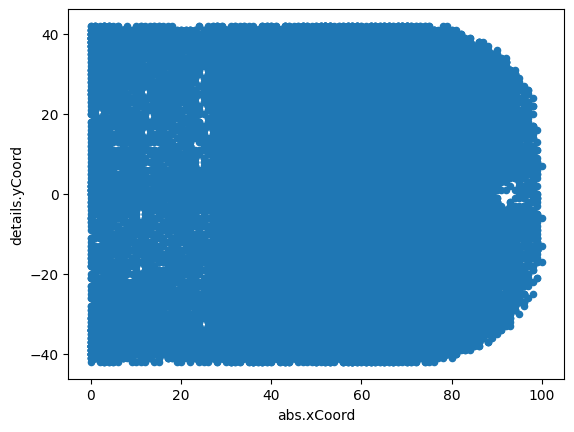

In [20]:
ax2 = train_pbp_krzy05.plot.scatter(x='abs.xCoord',y='details.yCoord',colormap='viridis')

In [ ]:
# Next handle shots from the other side of center, so need to determine which way shot is being taken